In [1]:
import openseespy.opensees as ops
import numpy as np
import opsvis as ovs
import matplotlib.pyplot as plt

In [2]:
ops.wipe()
ops.model('BasicBuilder', '-ndm', 1, '-ndf', 1)

ops.node(1, 0)
ops.node(2, 0)

ops.fix(1, 1)
ops.mass(2, 75.0e3)



#for kelvin voigt material
k =  93500e3
c = 520e3
kg = k
ops.uniaxialMaterial('Elastic', 1, k) #kelvin voigt
ops.uniaxialMaterial('Viscous', 2, c, 1)
ops.uniaxialMaterial('Parallel', 3, *[1, 2])


#add kelvin voigt element
ops.element('zeroLength', 1, *[1,2], '-mat', 3, '-dir', 1)


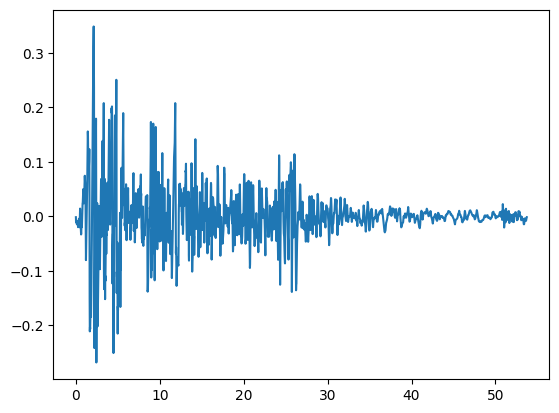

In [3]:
eqDataElCentro = np.loadtxt('data/elcentro.txt')
time = eqDataElCentro[:, 0]
accel = eqDataElCentro[:, 1]
plt.plot(time, accel)

In [4]:
DtAnalysis = 0.01 #for analysis
TmaxAnalysis = 10 #for analysis
Nstep = int(TmaxAnalysis/DtAnalysis)

GM_dirn = 1
GM_fact = 1.0*9.81
gmTS = 1
dt = 0.01		# time step for input ground motion

#for elcentro
#ops.timeSeries("Path", gmTS, '-time', *time, '-values', *accel)

# for others
ops.timeSeries("Path", gmTS, '-time', *time, '-values', *accel)

#pattern('UniformExcitation', patternTag, dir, '-disp', dispSeriesTag, '-vel', velSeriesTag, '-accel', accelSeriesTag, '-vel0', vel0, '-fact', fact)
ops.pattern('UniformExcitation', 1, GM_dirn, '-accel', gmTS, '-factor', GM_fact)


######## RECORDERS #########
ops.recorder('Node', '-file', 'left_corner.txt', '-time', '-closeOnWrite','-node',2 , '-dof', 1, 'disp')

ops.recorder('Node', '-file', 'left_corner_vel.txt', '-time', '-closeOnWrite','-node',2 , '-dof', 1, 'vel')


#ops.recorder('Element', '-file', 'eppDisplacement.txt', '-time', '-closeOnWrite','-ele',1 , '-dof', 1, 'deformation')
ops.recorder('Element', '-file', 'Reactions.txt', '-time', '-closeOnWrite','-ele',1 , '-dof', 1, 'force')



ops.constraints("Transformation")
ops.numberer("Plain")
ops.system("ProfileSPD")
tol = 1.e-8
maxNumIter = 50
ops.test("EnergyIncr", tol, maxNumIter)
ops.algorithm("ModifiedNewton")
ops.integrator("Newmark", .5, .25)
ops.analysis("Transient")

for i in range(Nstep):
    status = ops.analyze(1, DtAnalysis)
    # ovs.plot_defo()
    # plt.savefig(f'test_images/{(i+1)*DtAnalysis}s_{TmaxAnalysis}.png')
    # plt.close()
    print(f"Ground Motion - {i+1}/{Nstep}")
    if status != 0:
        print("Analysis failed trying Krylov Newton...")
        ops.algorithm('KrylovNewton')
        status = ops.analyze(1, DtAnalysis)
    if status != 0:
        print("Analysis failed trying with more iterations and less tolerance...")
        tol = 1.e-6
        maxNumIter = 100
        ops.system("BandSPD")
        ops.test("RelativeNormDispIncr", tol, maxNumIter)
        status = ops.analyze(1, DtAnalysis)
    if status!=0:
        print("Analysis failed trying Bryoden Algorithm")
        tol = 1.e-8
        maxNumIter = 50
        ops.test("EnergyIncr", tol, maxNumIter)
        ops.algorithm('Broyden')
        status = ops.integrator("HHT", 0.85, .5, .25)
        status = ops.analyze(1, DtAnalysis)
        #
    if status != 0:
        print("Breaking analysis")
        break
    
    ops.algorithm('ModifiedNewton')
    ops.system("ProfileSPD")
    tol = 1.e-10
    maxNumIter = 50    
    ops.test("EnergyIncr", tol, maxNumIter)
 

Ground Motion - 1/1000
Ground Motion - 2/1000
Ground Motion - 3/1000
Ground Motion - 4/1000
Ground Motion - 5/1000
Ground Motion - 6/1000
Ground Motion - 7/1000
Ground Motion - 8/1000
Ground Motion - 9/1000
Ground Motion - 10/1000
Ground Motion - 11/1000
Ground Motion - 12/1000
Ground Motion - 13/1000
Ground Motion - 14/1000
Ground Motion - 15/1000
Ground Motion - 16/1000
Ground Motion - 17/1000
Ground Motion - 18/1000
Ground Motion - 19/1000
Ground Motion - 20/1000
Ground Motion - 21/1000
Ground Motion - 22/1000
Ground Motion - 23/1000
Ground Motion - 24/1000
Ground Motion - 25/1000
Ground Motion - 26/1000
Ground Motion - 27/1000
Ground Motion - 28/1000
Ground Motion - 29/1000
Ground Motion - 30/1000
Ground Motion - 31/1000
Ground Motion - 32/1000
Ground Motion - 33/1000
Ground Motion - 34/1000
Ground Motion - 35/1000
Ground Motion - 36/1000
Ground Motion - 37/1000
Ground Motion - 38/1000
Ground Motion - 39/1000
Ground Motion - 40/1000
Ground Motion - 41/1000
Ground Motion - 42/1000
G

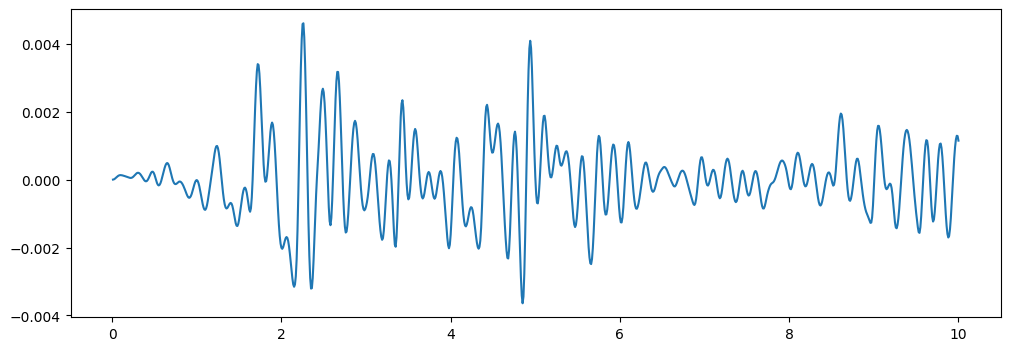

In [5]:
left_node_disp=np.loadtxt('left_corner.txt',delimiter = " ")

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(left_node_disp[:,0],left_node_disp[:,1])



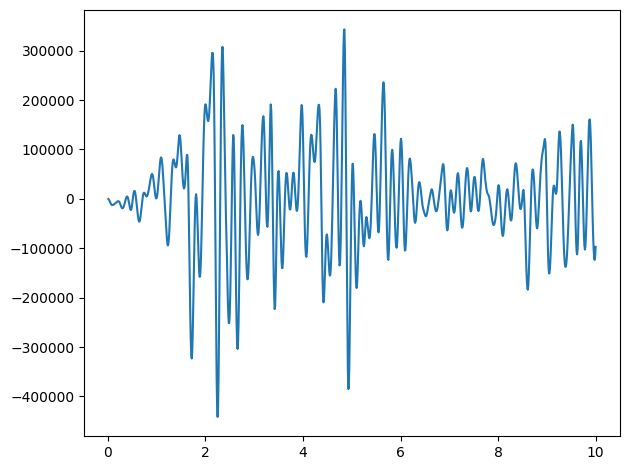

In [6]:
forceKelvinVoigt=np.loadtxt('Reactions.txt',delimiter = " ")

fig,axis = plt.subplots()
axis.plot(forceKelvinVoigt[:,0],forceKelvinVoigt[:,1])
#axis[0].plot(forceKelvinVoigt[:,0],forceKelvinVoigt[:,1])
#axis[0].plot(forceEPP[:,0],forceEPP[:,1])
#plt.xlim([1.3,1.4])
plt.tight_layout()

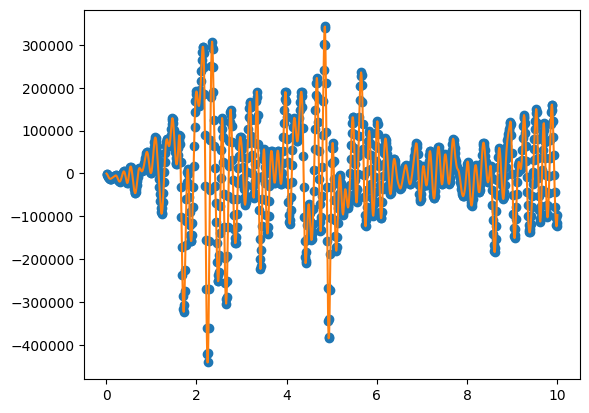

In [7]:
left_node_vel=np.loadtxt('left_corner_vel.txt',delimiter = " ")

time = left_node_vel[:,0]

#print(right_node_vel)
# left_node_disp, right_node_disp
force = np.zeros_like(left_node_disp[:, 1])
force = k * (0 - left_node_disp[:,1]) + c *(- left_node_vel[:,1])
# collision = left_node_disp[:,1] - right_node_disp[:,1] - gap
# iscollided = collision >= 0
# force[~iscollided] = 0

#print(len(time), len(force))
plt.plot(time, force, 'o')
plt.plot(forceKelvinVoigt[:,0],forceKelvinVoigt[:,1])


In [8]:
for i in range(len(forceKelvinVoigt[:,1])):
    print(force[i], forceKelvinVoigt[i, 1])

-282.67582500000003 -282.676
-1282.0253699999998 -1282.02
-3009.50495 -3009.51
-5172.53805 -5172.54
-7445.1885999999995 -7445.19
-9496.704450000001 -9496.7
-11090.804799999998 -11090.8
-12103.9624 -12104.0
-12527.99942 -12528.0
-12463.327371999998 -12463.4
-12052.244279999999 -12052.2
-11461.40262 -11461.4
-10784.839 -10784.8
-10041.247500000001 -10041.2
-9251.41804 -9251.38
-8431.14265 -8431.14
-7583.24109 -7583.24
-6698.10255 -6698.1
-5829.912 -5829.92
-5082.19839 -5082.2
-4641.16779 -4641.17
-4745.946164 -4745.95
-5548.30171 -5548.3
-7106.31575 -7106.31
-9323.487299999999 -9323.49
-11973.2892 -11973.3
-14680.711299999999 -14680.7
-16978.7862 -16978.8
-18517.3724 -18517.4
-19088.7002 -19088.7
-18568.05498 -18568.1
-16927.3673 -16927.4
-14296.557600000002 -14296.5
-10934.8159 -10934.8
-7136.48115 -7136.48
-3196.9529499999994 -3196.95
440.9922999999999 440.992
3258.27525 3258.27
4778.43825 4778.44
4617.823776 4617.82
2633.24075 2633.24
-1082.65178 -1082.65
-6118.6807 -6118.68
-11819.70

In [9]:
ops.wipe()
ops.model('BasicBuilder', '-ndm', 1, '-ndf', 1)

ops.node(1, 0)
ops.node(2, 0)

ops.fix(1, 1)
ops.mass(2, 75.0e3)



#for kelvin voigt material
k =  93500e3
c = 520e3
kg = 100*k
ops.uniaxialMaterial('Elastic', 1, k) #kelvin voigt
ops.uniaxialMaterial('Viscous', 2, c, 1)
#ops.uniaxialMaterial('Parallel', 3, *[1, 2])


#add kelvin voigt element
ops.element('zeroLength', 1, *[1,2], '-mat', 1, '-dir', 1)
ops.element('zeroLength', 2, *[1,2], '-mat', 2, '-dir', 1)

In [10]:
eqDataElCentro = np.loadtxt('data/elcentro.txt')
time = eqDataElCentro[:, 0]
accel = eqDataElCentro[:, 1]

DtAnalysis = 0.01 #for analysis
TmaxAnalysis = 10 #for analysis
Nstep = int(TmaxAnalysis/DtAnalysis)

GM_dirn = 1
GM_fact = 1.0*9.81
gmTS = 1
dt = 0.01		# time step for input ground motion

#for elcentro
#ops.timeSeries("Path", gmTS, '-time', *time, '-values', *accel)

# for others
ops.timeSeries("Path", gmTS, '-time', *time, '-values', *accel)

#pattern('UniformExcitation', patternTag, dir, '-disp', dispSeriesTag, '-vel', velSeriesTag, '-accel', accelSeriesTag, '-vel0', vel0, '-fact', fact)
ops.pattern('UniformExcitation', 1, GM_dirn, '-accel', gmTS, '-factor', GM_fact)


######## RECORDERS #########
ops.recorder('Node', '-file', 'left_corner.txt', '-time', '-closeOnWrite','-node',2 , '-dof', 1, 'disp')

ops.recorder('Node', '-file', 'left_corner_vel.txt', '-time', '-closeOnWrite','-node',2 , '-dof', 1, 'vel')


#ops.recorder('Element', '-file', 'eppDisplacement.txt', '-time', '-closeOnWrite','-ele',1 , '-dof', 1, 'deformation')
ops.recorder('Element', '-file', 'ReactionsViscous.txt', '-time', '-closeOnWrite','-ele',2 , '-dof', 1, 'force')
ops.recorder('Element', '-file', 'ReactionsElastic.txt', '-time', '-closeOnWrite','-ele',1 , '-dof', 1, 'force')


ops.constraints("Transformation")
ops.numberer("Plain")
ops.system("ProfileSPD")
tol = 1.e-8
maxNumIter = 50
ops.test("EnergyIncr", tol, maxNumIter)
ops.algorithm("ModifiedNewton")
ops.integrator("Newmark", .5, .25)
ops.analysis("Transient")

for i in range(Nstep):
    status = ops.analyze(1, DtAnalysis)
    # ovs.plot_defo()
    # plt.savefig(f'test_images/{(i+1)*DtAnalysis}s_{TmaxAnalysis}.png')
    # plt.close()
    print(f"Ground Motion - {i+1}/{Nstep}")
    if status != 0:
        print("Analysis failed trying Krylov Newton...")
        ops.algorithm('KrylovNewton')
        status = ops.analyze(1, DtAnalysis)
    if status != 0:
        print("Analysis failed trying with more iterations and less tolerance...")
        tol = 1.e-6
        maxNumIter = 100
        ops.system("BandSPD")
        ops.test("RelativeNormDispIncr", tol, maxNumIter)
        status = ops.analyze(1, DtAnalysis)
    if status!=0:
        print("Analysis failed trying Bryoden Algorithm")
        tol = 1.e-8
        maxNumIter = 50
        ops.test("EnergyIncr", tol, maxNumIter)
        ops.algorithm('Broyden')
        status = ops.integrator("HHT", 0.85, .5, .25)
        status = ops.analyze(1, DtAnalysis)
        #
    if status != 0:
        print("Breaking analysis")
        break
    
    ops.algorithm('ModifiedNewton')
    ops.system("ProfileSPD")
    tol = 1.e-10
    maxNumIter = 50    
    ops.test("EnergyIncr", tol, maxNumIter)
 

Ground Motion - 1/1000
Ground Motion - 2/1000
Ground Motion - 3/1000
Ground Motion - 4/1000
Ground Motion - 5/1000
Ground Motion - 6/1000
Ground Motion - 7/1000
Ground Motion - 8/1000
Ground Motion - 9/1000
Ground Motion - 10/1000
Ground Motion - 11/1000
Ground Motion - 12/1000
Ground Motion - 13/1000
Ground Motion - 14/1000
Ground Motion - 15/1000
Ground Motion - 16/1000
Ground Motion - 17/1000
Ground Motion - 18/1000
Ground Motion - 19/1000
Ground Motion - 20/1000
Ground Motion - 21/1000
Ground Motion - 22/1000
Ground Motion - 23/1000
Ground Motion - 24/1000
Ground Motion - 25/1000
Ground Motion - 26/1000
Ground Motion - 27/1000
Ground Motion - 28/1000
Ground Motion - 29/1000
Ground Motion - 30/1000
Ground Motion - 31/1000
Ground Motion - 32/1000
Ground Motion - 33/1000
Ground Motion - 34/1000
Ground Motion - 35/1000
Ground Motion - 36/1000
Ground Motion - 37/1000
Ground Motion - 38/1000
Ground Motion - 39/1000
Ground Motion - 40/1000
Ground Motion - 41/1000
Ground Motion - 42/1000
G

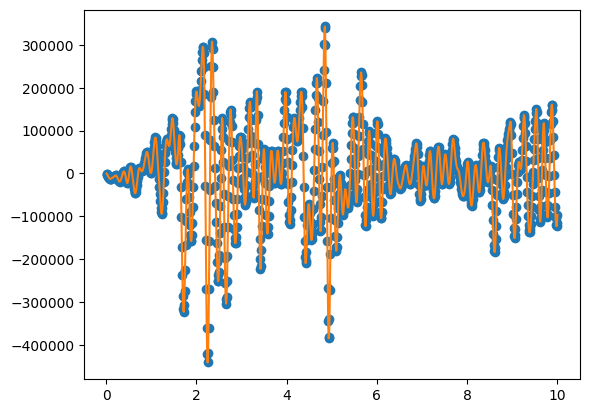

In [11]:
left_node_disp2=np.loadtxt('left_corner.txt',delimiter = " ")
forceViscous=np.loadtxt('ReactionsViscous.txt',delimiter = " ")
forceElastic=np.loadtxt('ReactionsElastic.txt',delimiter = " ")
left_node_vel2=np.loadtxt('left_corner_vel.txt',delimiter = " ")

time = left_node_vel2[:,0]

#print(right_node_vel)
# left_node_disp, right_node_disp
forceKelvinVoigt2 = forceViscous[:,1]+forceElastic[:,1]
#force2 = np.zeros_like(left_node_disp2[:, 1])
force2 = k * (0 - left_node_disp2[:,1]) + c *(- left_node_vel2[:,1])
# collision = left_node_disp[:,1] - right_node_disp[:,1] - gap
# iscollided = collision >= 0
# force[~iscollided] = 0

#print(len(time), len(force))
plt.plot(time, force2, 'o')
plt.plot(time,forceKelvinVoigt2)



In [12]:
for i in range(len(forceKelvinVoigt[:,1])):
    print(force2[i], forceKelvinVoigt2[i], force[i], forceKelvinVoigt[i, 1])

-282.67582500000003 -282.67600000000004 -282.67582500000003 -282.676
-1282.0253699999998 -1282.0230000000001 -1282.0253699999998 -1282.02
-3009.50495 -3009.509 -3009.50495 -3009.51
-5172.53805 -5172.54 -5172.53805 -5172.54
-7445.1885999999995 -7445.1900000000005 -7445.1885999999995 -7445.19
-9496.704450000001 -9496.710000000001 -9496.704450000001 -9496.7
-11090.804799999998 -11090.827 -11090.804799999998 -11090.8
-12103.9624 -12103.998 -12103.9624 -12104.0
-12527.99942 -12527.961 -12527.99942 -12528.0
-12463.327371999998 -12463.3879 -12463.327371999998 -12463.4
-12052.244279999999 -12052.225999999999 -12052.244279999999 -12052.2
-11461.40262 -11461.417000000001 -11461.40262 -11461.4
-10784.839 -10784.848999999998 -10784.839 -10784.8
-10041.247500000001 -10041.202000000001 -10041.247500000001 -10041.2
-9251.41804 -9251.380000000001 -9251.41804 -9251.38
-8431.14265 -8431.14 -8431.14265 -8431.14
-7583.24109 -7583.240000000001 -7583.24109 -7583.24
-6698.10255 -6698.107999999999 -6698.10255